In [1]:
 # フォントを全て読み込み
import matplotlib.pyplot as plt
import japanize_matplotlib

fonts = set([f.name for f in 
             matplotlib.font_manager.fontManager.ttflist])
plt.rcParams['font.family'] = "MS Gothic"

In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t
from scipy.stats import chi2
import seaborn as sns

In [3]:
end='2022/12/31'
n225 = web.DataReader("NIKKEI225", 'fred',"1949/5/16",end).dropna()

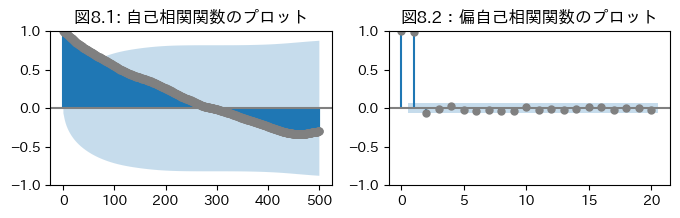

In [4]:
lnn225=np.log(n225)
lnn225M=lnn225.resample('ME').last()
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(1,2,1)
fig = sm.graphics.tsa.plot_acf(lnn225M,lags=500,color='gray',
                               ax=ax1)
plt.title('図8.1: 自己相関関数のプロット')
ax2 = fig.add_subplot(1,2,2)
fig = sm.graphics.tsa.plot_pacf(lnn225M,method='ywm',
                                lags=20,color='gray', ax=ax2)
plt.title('図8.2：偏自己相関関数のプロット')
#plt.savefig("図8.1.jpeg",dpi=600)
plt.show()

In [5]:
y=lnn225M.iloc[1:].copy()
x=lnn225M.iloc[:-1].copy()
x=sm.add_constant(x.values)
ar1_res=sm.OLS(y,x).fit() 

const = ar1_res.params['const']
phi   = ar1_res.params[1] if 1 in ar1_res.params.index else ar1_res.params['x1']

p_const = ar1_res.pvalues['const']
p_phi   = ar1_res.pvalues[1] if 1 in ar1_res.pvalues.index else ar1_res.pvalues['x1']

print(f'係数- 切片: {const:0.4f} 1次の回帰係数: {phi:0.4f}')
print(f'p値 - 切片: {p_const:0.4f}, 1次の回帰係数: {p_phi:0.4f}')

係数- 切片: 0.0320 1次の回帰係数: 0.9969
p値 - 切片: 0.0049, 1次の回帰係数: 0.0000


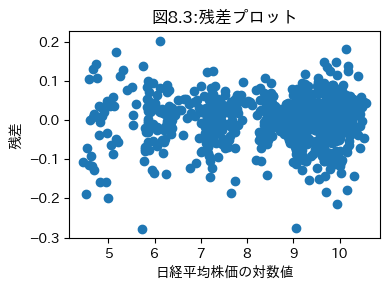

In [6]:
resid=pd.DataFrame(ar1_res.resid.values,index=lnn225M.NIKKEI225.values[1:],
                   columns=['残差'])
plt.figure(figsize=(4,3))
plt.scatter(resid.index,resid)
plt.xlabel("日経平均株価の対数値")
plt.ylabel("残差")
plt.title("図8.3:残差プロット")
plt.tight_layout()
#plt.savefig('図8.3.jpeg',dpi=600)
plt.show()

In [7]:
m=resid.mean().iloc[0]
n=resid.count().iloc[0]
v=resid.std().iloc[0]*np.sqrt((n-1)/(n-2))
print(f"平均:              {m:2.4f} 標準偏差：          {v:2.4f}")

平均:              0.0000 標準偏差：          0.0577


In [8]:
def ploterrorbar(tsd,yerr,xlabel,ylabel,name):
    fig = plt.figure(figsize=(4,3))
    plt.errorbar(tsd.index,tsd.values,yerr.values,
             label='信頼区間')    
    plt.xlabel('日時')
    plt.ylabel('残差')
    plt.title(name)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    #plt.savefig(name[:4]+".jpeg",dpi=600)
    plt.show()

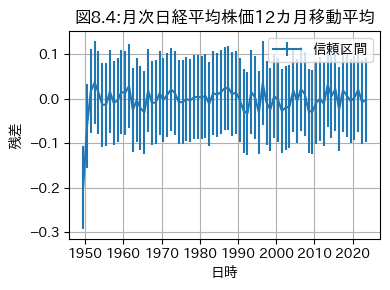

In [9]:
tsd=pd.DataFrame(ar1_res.resid.values,index=ar1_res.resid.index,
                 columns=['resid'])
resid_12Mmean=tsd.resid.resample("12ME").mean()#.iloc[1:]
conf_upper=resid_12Mmean+1.36*np.sqrt(v)/np.sqrt(12)
conf_lower=resid_12Mmean-1.36*np.sqrt(v)/np.sqrt(12)
yerr=(conf_upper-conf_lower).fillna(0)/2
ploterrorbar(resid_12Mmean,yerr,'日時','残差',
             '図8.4:月次日経平均株価12カ月移動平均')

In [10]:
tt=(m-0)/v/np.sqrt(n)
p=t.cdf(tt,n-1)
p,tt,n

(np.float64(0.5000000000000008),
 np.float64(1.8908292946468894e-15),
 np.int64(883))

In [11]:
tsd1=tsd[tsd.index.year<1970].copy()
tsd2=tsd[(tsd.index.year>=1970)&(tsd.index.year<1980)].copy()
tsd3=tsd[(tsd.index.year>=1980)&(tsd.index.year<1990)].copy()
tsd4=tsd[(tsd.index.year>=1990)&(tsd.index.year<2000)].copy()
tsd5=tsd[(tsd.index.year>=2000)&(tsd.index.year<2010)].copy()
tsd6=tsd[(tsd.index.year>=2010)].copy()
tsd1["flg"]=1
tsd2["flg"]=2
tsd3["flg"]=3
tsd4["flg"]=4
tsd5["flg"]=5
tsd6["flg"]=6
tsd=pd.concat([tsd1,tsd2,tsd3,tsd4,tsd5,tsd6])

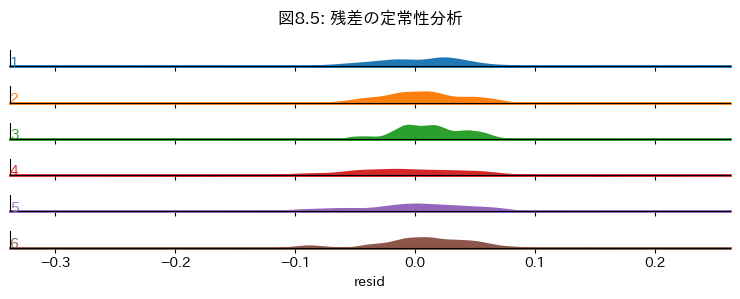

In [12]:
g=np.array([str(y) for y in tsd.flg])
# FacetGrid オブジェクトの初期化
g = sns.FacetGrid(tsd, row="flg", hue="flg", aspect=15, height=0.5)
g.map(sns.kdeplot, "resid",bw_adjust=.5, clip_on=False,fill=True, alpha=1, 
      linewidth=1.5)
g.map(sns.kdeplot, "resid", clip_on=False, color="w", lw=2, bw_adjust=.5)
# hueマッピングを用いてrefline()に色を渡す
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
def label(x, color, label):# 適切な軸の範囲を指定
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "resid")
g.figure.subplots_adjust(hspace=-.15)
g.set_titles('')
g.set(yticks=[], ylabel="")
g.fig.suptitle("図8.5: 残差の定常性分析")
plt.tight_layout()
#plt.savefig('図8.5.jpeg',dpi=600)
plt.show()

In [13]:
p=sm.tsa.adfuller(ar1_res.resid,regression='n')[1] #[1]はp値の検定結果
p1=sm.tsa.adfuller(ar1_res.resid,regression='c')[1] #[1]はp値の検定結果
print(f"ドリフト無しランダムウォーク p値:{p:0.4f}")
print(f"ドリフト付きランダムウォーク p値:{p1:0.4f}")

ドリフト無しランダムウォーク p値:0.0000
ドリフト付きランダムウォーク p値:0.0000


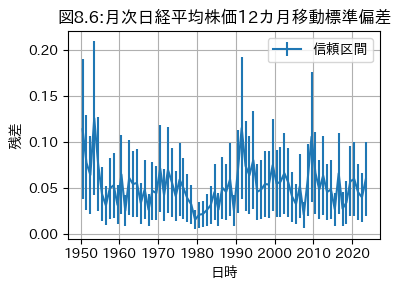

In [14]:
resid_12Mstd=tsd.resid.resample("12ME").std().iloc[1:]
conf_upper=resid_12Mstd*11/5.58
conf_lower=resid_12Mstd*11/17.28
yerr=(conf_upper-conf_lower).fillna(0)/2
ploterrorbar(resid_12Mstd,yerr,'日時','残差',\
              '図8.6:月次日経平均株価12カ月移動標準偏差')

In [15]:
print(f"信頼区間が母標準偏差を含まない確率:\
    {conf_upper[conf_upper<v].count()/conf_upper.count():2.4f}")

信頼区間が母標準偏差を含まない確率:    0.1486


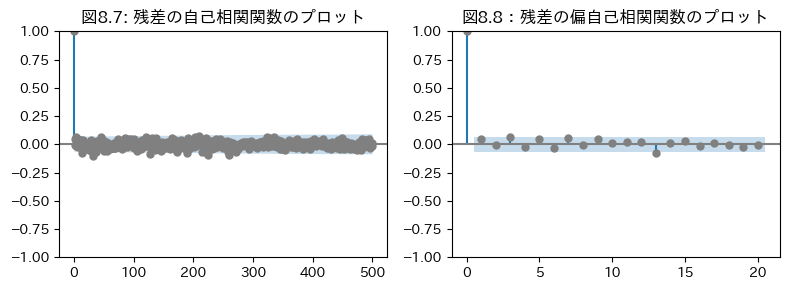

In [16]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(1,2,1)
fig = sm.graphics.tsa.plot_acf(ar1_res.resid,lags=500,color='gray',
                               ax=ax1)
plt.title('図8.7: 残差の自己相関関数のプロット')
ax2 = fig.add_subplot(1,2,2)
fig = sm.graphics.tsa.plot_pacf(ar1_res.resid,method='ywm',
                                lags=20,color='gray', ax=ax2)
plt.title('図8.8：残差の偏自己相関関数のプロット')
plt.tight_layout()
#plt.savefig("図8.7.jpeg",dpi=800)
plt.show()

In [17]:
acf,q,pvalue = sm.tsa.acf(ar1_res.resid,nlags=2)
a = sm.tsa.acf(ar1_res.resid,nlags=2)
pacf,confint = sm.tsa.pacf(ar1_res.resid,nlags=2,alpha=0.05)
print(f"0次自己相関係数：{acf},p値:{pvalue:2.4f}")
print('')
print(f"1次偏自己相関: {pacf[1]:2.4f} 95％信頼区間: {confint[1,0:2]}")
print(f"2次偏自己相関: {pacf[2]:2.4f} 95％信頼区間: {confint[2,0:2]}")

0次自己相関係数：1.0,p値:-0.0032

1次偏自己相関: 0.0498 95％信頼区間: [-0.01610822  0.11580786]
2次偏自己相関: -0.0057 95％信頼区間: [-0.07169187  0.06022421]


In [18]:
resid_x=pd.concat([lnn225M.shift().dropna(),ar1_res.resid],axis=1)
resid_x.columns=['lnn225','resid']
num=int(len(resid_x)/12)*12
ind=ar1_res.resid.iloc[-num+12:].resample('12ME').last().index
x=lnn225M.shift().dropna().values[-num:]
x=x.squeeze()
x=x.reshape([-1,12])
r=ar1_res.resid.iloc[-num:].values.reshape([-1,12])
cv=np.array([np.corrcoef(z1,z2)[0,1] for z1,z2 in zip(x,r)])
z=1/2*np.log((1+cv)/(1-cv))
z1=z-1.64*np.sqrt(1/(12-3))
z2=z+1.64*np.sqrt(1/(12-3))
cv_lower=(np.exp(2*z1)-1)/(np.exp(2*z1)+1)
cv_upper=(np.exp(2*z2)-1)/(np.exp(2*z2)+1)
yerr=[]
for a,b,c in zip(cv_upper,cv_lower,cv):
    if (a<0 and b<0)or(a>0 and b>0):
        yerr.append((a-b)/2)
    else:
        yerr.append((a-c))


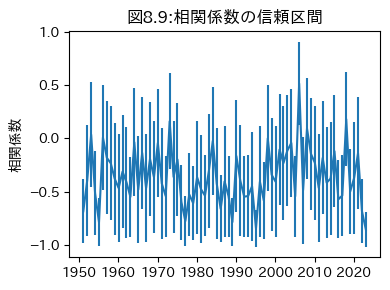

In [19]:
plt.figure(figsize=(4,3))
plt.errorbar(ind,cv,yerr,label='信頼区間')
plt.title('図8.9:相関係数の信頼区間')
plt.ylabel("相関係数")
plt.tight_layout()
#plt.savefig("図8.9.jpeg",dpi=800)
plt.show()

In [20]:
cv_upper=pd.Series(cv_upper)
print(f"信頼区間が母標準偏差を含まない確率:\
    {cv_upper[cv_upper<0].count()/cv_upper.count():2.4f}")

信頼区間が母標準偏差を含まない確率:    0.3151


In [21]:
def ar1_plus_drift(tsd):
    yy=tsd.iloc[1:].copy()
    x=tsd.iloc[:-1].copy()
    x["t"]=np.arange(len(x))
    x=sm.add_constant(x.values)
    return sm.OLS(yy,x).fit()

In [22]:
def uroot_or_ar1(tsd,interval,adf):
    results=[]
    for nnn in interval:
        jb=nn=0
        no=int(len(tsd)/nnn)
        for i in range(no):
            if i<no-1:
                y=tsd.iloc[i*nnn:(1+i)*nnn].copy()
            else:
                y=tsd.iloc[i*nnn:-1].copy()
            if sm.tsa.adfuller(y,regression=adf)[1]<0.1:               
                res=ar1_plus_drift(y) 
                if jarque_bera(res.resid.values)[1]<0.1:
                    jb+=1
                nn+=1
        if nn>0:
            results.append([nnn,no,np.round(jb/nn,2),np.round(nn/no,2)])
        else:
            results.append([nnn,int(len(tsd)/nnn),0,0])
    return pd.DataFrame(results,columns=['時間枠','時間枠数','JB棄却率',
                                         'ur棄却率'])

In [23]:
uroot_or_ar1(lnn225,np.arange(20,130,40),"c")

,時間枠,時間枠数,JB棄却率,ur棄却率
0,20,914,0.09,0.30
1,60,304,0.25,0.14
2,100,182,0.57,0.13


In [24]:
uroot_or_ar1(lnn225.resample('QE').last(),np.arange(4,21,4),"c")

,時間枠,時間枠数,JB棄却率,ur棄却率
0,4,73,0.00,0.19
1,8,36,0.08,0.36
2,12,24,0.00,0.38
3,16,18,0.20,0.28
4,20,14,0.00,0.07
